In [253]:
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Create spatial map and helper functions
Spatial map is used to convert PUMA and County back to ResStock input format

In [254]:
spatial_file = (
    Path("__file__").resolve().parents[2] / 
"resstock-estimation" / "data_download" / "spatial_data_v2" /
"spatial_tract_lookup_table.csv"
) # this file should be in your local resstock-estimation repo (if not available, you'll need to run the sources/spatial/tsv_maker.py to trigger a download from S3)
dfs = pd.read_csv(spatial_file, low_memory=False)

# create geospatial maps
puma_map = dfs[["nhgis_2010_puma_gisjoin", "puma_tsv"]].drop_duplicates()\
    .set_index("puma_tsv")["nhgis_2010_puma_gisjoin"]
county_map = dfs[["nhgis_2010_county_gisjoin", "county_name"]].drop_duplicates()\
    .set_index("county_name")["nhgis_2010_county_gisjoin"]

In [288]:
## unit conversion factors
kwh_to_mmbtu = 3412.14/1e6
kwh_to_therm = 3412.14/1e5 # (we use 10 therm = 1 mmbtu)

def extract_left_edge(val):
    # for sorting things like AMI
    if val is None:
        return np.nan
    if not isinstance(val, str):
        return val
    first = val[0]
    if first in ["<", ">"] or first.isdigit():
        vals = [int(x) for x in re.split("\-|\%|\<|\+|\>|s", val) if re.match("\d", x)]
        if len(vals) > 0:
            num = vals[0]
            if "<" in val:
                num -= 1
            if ">" in val:
                num += 1
            return num
    return val

def sort_index(df, axis="index", **kwargs):
    """ axis: ['index', 'columns'] """
    if axis in [0, "index"]:
        return df.reindex(sorted(df.index, key=extract_left_edge, **kwargs))
    if axis in [1, "columns"]:
        col_index_name = df.columns.name
        cols = sorted(df.columns, key=extract_left_edge, **kwargs)
        df = df[cols]
        df.columns.name = col_index_name
        return df
    raise ValueError(f"axis={axis} is invalid")

# for calculating fractional (relative to baseline) saving:
def calculate_fraction_savings(df):
    saving_cols = [col for col in df.columns if "savings" in col]
    energy_cols = [col.removesuffix(".savings") for col in saving_cols] # energy after upgrade

    for scol, ecol in zip(saving_cols, energy_cols):
        pct_col = ".".join(ecol.split(".")[:-1]) + ".fraction_savings"
        df[pct_col] = df[scol].divide((df[ecol]+df[scol]), axis=0)

    return df

# for conslidating FPL and AMI
def remap_federal_poverty(df):
    df["FPL"] = df["in.federal_poverty_level"].map(
        {
            "0-100%": "<200% FPL",
            "100-150%": "<200% FPL",
            "150-200%": "<200% FPL",
            "200-300%": "200%+ FPL",
            "300-400%": "200%+ FPL",
            "400%+": "200%+ FPL",
        }
    )
    return df

def remap_area_median_income(df):
    df["AMI"] = df["in.area_median_income"].map(
        {
            "0-30%": "<80% AMI",
            "30-60%": "<80% AMI",
            "60-80%": "<80% AMI",
            "80-100%": "80-150% AMI",
            "100-120%": "80-150% AMI",
            "120-150%": "80-150% AMI",
            "150%+": "150%+ AMI",
        }
    )
    return df

### Community
- Highland Park, MI : MI, Wayne County | MI, 03213

In [294]:
## specify the pumas and counties of your choice 
# these correspond to what is in ResStock, for reference on options, see options_lookup.py
# (https://github.com/NREL/resstock/blob/develop/resources/options_lookup.tsv)
pumas = ["MI, 03213"] # <--- 
counties = ["MI, Wayne County"] # <---

gis_pumas = [puma_map[p] for p in pumas]
gis_counties = [county_map[c] for c in counties]
print(f"{pumas} --> {gis_pumas}")
print(f"{counties} --> {gis_counties}")

['MI, 03213'] --> ['G26003213']
['MI, Wayne County'] --> ['G2601630']


### Specify path to metadata_and_annual_results file

In [257]:
# specify input data directory and file
# I am using the national version here
datadir = Path("/Users/lliu2/Documents/GitHub/ResStock/IRA_analysis/data") # <---
file = datadir / "upgrade10_metadata_and_annual_results.csv" # "baseline_metadata_and_annual_results.csv"

In [295]:
# read file and add consolidated AMI and FPL columns
df = pd.read_csv(file, low_memory=False)
df = remap_area_median_income(df)
df = remap_federal_poverty(df)

### A. Explore housing characteristics

in.geometry_building_type_recs
Mobile Home                      0.009569
Multi-Family with 2 - 4 Units    0.095694
Multi-Family with 5+ Units       0.086124
Single-Family Attached           0.076555
Single-Family Detached           0.732057
Name: bldg_id, dtype: float64


<AxesSubplot:xlabel='in.geometry_building_type_recs', ylabel='Prevalence (fraction of unit count)'>

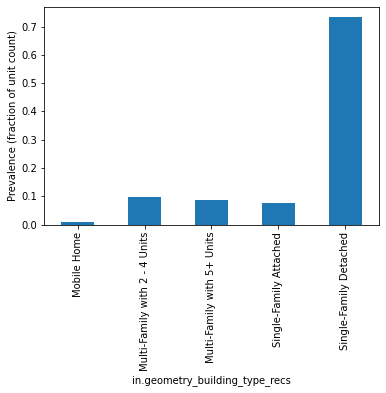

In [259]:
# Example 1: get breakdown of building type in specified PUMA
# here we are using count of bldg_id, you can definitely sum "weight" col to get total representative count
cond = df["in.puma"].isin(gis_pumas)
features = ["in.geometry_building_type_recs"]
breakdown = sort_index(df.loc[cond].groupby(features)["bldg_id"].count() / len(df.loc[cond]))
print(breakdown)

# in graphical form
breakdown.plot(kind="bar", ylabel="Prevalence (fraction of unit count)")

in.geometry_building_type_recs  in.heating_fuel
Mobile Home                     Natural Gas         0.956938
Multi-Family with 2 - 4 Units   Electricity         0.478469
                                Natural Gas         9.090909
Multi-Family with 5+ Units      Electricity         2.392344
                                Natural Gas         6.220096
Single-Family Attached          Natural Gas         7.655502
Single-Family Detached          Electricity         2.870813
                                Natural Gas        69.856459
                                Other Fuel          0.478469
Name: weight, dtype: float64
same data but in subplots


array([<AxesSubplot:title={'center':'Electricity'}, xlabel='in.geometry_building_type_recs', ylabel='% unit count'>,
       <AxesSubplot:title={'center':'Natural Gas'}, xlabel='in.geometry_building_type_recs', ylabel='% unit count'>,
       <AxesSubplot:title={'center':'Other Fuel'}, xlabel='in.geometry_building_type_recs', ylabel='% unit count'>],
      dtype=object)

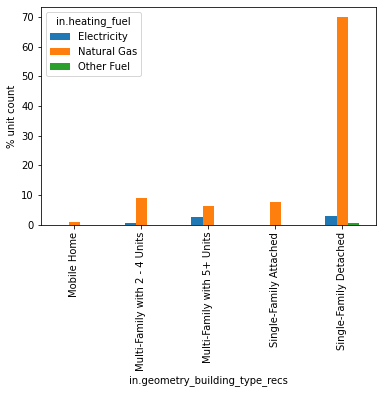

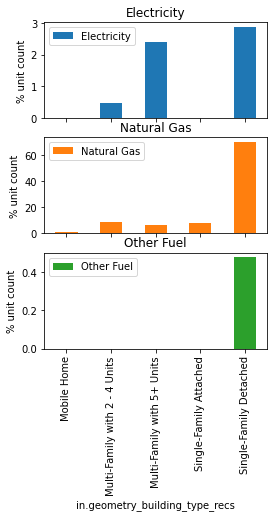

In [260]:
# Example 2: get % breakdown of building type + heating fuel in specified PUMA
# here we are using sum of "weight" to calculate %, should be the same
cond = df["in.puma"].isin(gis_pumas)
features = ["in.geometry_building_type_recs", "in.heating_fuel"]
breakdown = sort_index(df.loc[cond].groupby(features)["weight"].sum() / df.loc[cond, "weight"].sum()) * 100
print(breakdown)

# in graphical form (sum of all bar heights=100%)
breakdown.unstack(level=1).plot(kind="bar", ylabel="% unit count")
print("same data but in subplots")
breakdown.unstack(level=1).plot(kind="bar", subplots=True, figsize=(4,6), ylabel="% unit count")


in.geometry_building_type_recs  in.vintage_acs
Mobile Home                     2000-09             484.262025
Multi-Family with 2 - 4 Units   1940-59            1210.655064
                                1960-79             968.524051
                                2000-09             484.262025
                                <1940              2179.179115
Multi-Family with 5+ Units      1940-59            1452.786076
                                1960-79            1452.786076
                                1980-99             484.262025
                                2000-09             242.131013
                                <1940               726.393038
Single-Family Attached          1940-59            1452.786076
                                1960-79             484.262025
                                1980-99             242.131013
                                <1940              1694.917089
Single-Family Detached          1940-59           18644.087980
        

Text(0, 0.5, 'Housing unit count')

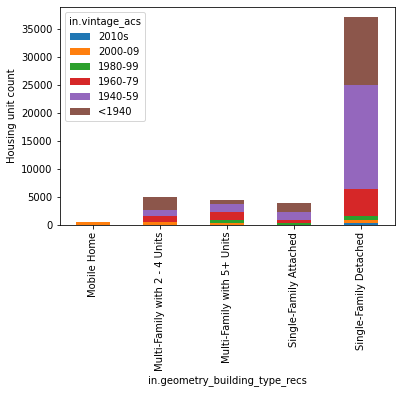

In [261]:
# Example 3: get breakdown of building type + vintage in specified PUMA - representative count (weight)
cond = df["in.puma"].isin(gis_pumas)
features = ["in.geometry_building_type_recs", "in.vintage_acs"]
breakdown = sort_index(df.loc[cond].groupby(features)["weight"].sum())
print(breakdown)

# in graphical form
sort_index(
    sort_index(breakdown.unstack(level=1), 
    axis="index"), axis="columns", reverse=True).plot(kind="bar", stacked=True)
plt.ylabel("Housing unit count")

In [262]:
## Using county instead of puma to filter down, do a sample count for some housing features
cond = df["in.county"].isin(gis_counties)
cond &= df["in.puma_metro_status"]=="In metro area, not/partially in principal city"
df.loc[cond, ["in.state", "in.city", "in.puma_metro_status"]]
df.loc[cond].groupby(["in.city"])["in.vintage"].count()

in.city
In another census Place    665
MI, Dearborn               143
MI, Dearborn Heights        91
MI, Detroit                 49
MI, Lincoln Park            65
MI, Livonia                161
MI, Taylor                 107
MI, Westland               152
Not in a census Place      474
Name: in.vintage, dtype: int64

### Set permanent location filter

In [296]:
cond = df["in.puma"].isin(gis_pumas)
applicable = df["applicability"]==True
df_filtered = df.loc[cond & applicable].copy()

# note the size of the dataframe
df_filtered

,bldg_id,upgrade,weight,applicability,in.sqft,in.ahs_region,in.ashrae_iecc_climate_zone_2004,in.ashrae_iecc_climate_zone_2004_2_a_split,in.bathroom_spot_vent_hour,in.bedrooms,...,upgrade.insulation_ceiling,upgrade.ducts,upgrade.hvac_heating_type,upgrade.insulation_wall,upgrade.insulation_foundation_wall,upgrade.hvac_heating_efficiency,upgrade.cooking_range,in.area_median_income,AMI,FPL
123,125,10,242.131013,True,1220.0,"CBSA Detroit-Warren-Dearborn, MI",5A,5A,Hour12,3,...,R-60,NaN,Ducted Heat Pump,NaN,NaN,"MSHP, SEER 24, 13 HSPF","Electric, Induction, 120% Usage",0-30%,<80% AMI,<200% FPL
7695,7715,10,242.131013,True,3138.0,"CBSA Detroit-Warren-Dearborn, MI",5A,5A,Hour4,2,...,NaN,"10% Leakage, R-8",Ducted Heat Pump,NaN,NaN,"MSHP, SEER 24, 13 HSPF","Electric, Induction, 120% Usage",120-150%,80-150% AMI,200%+ FPL
10707,10731,10,242.131013,True,2663.0,"CBSA Detroit-Warren-Dearborn, MI",5A,5A,Hour4,5,...,R-60,NaN,NaN,NaN,NaN,"MSHP, SEER 29.3, 14 HSPF, Max Load","Electric, Induction, 100% Usage",150%+,150%+ AMI,200%+ FPL
12852,12878,10,242.131013,True,3301.0,"CBSA Detroit-Warren-Dearborn, MI",5A,5A,Hour20,3,...,R-60,NaN,Ducted Heat Pump,"Wood Stud, R-13",NaN,"MSHP, SEER 24, 13 HSPF","Electric, Induction, 100% Usage",150%+,150%+ AMI,200%+ FPL
14196,14225,10,242.131013,True,885.0,"CBSA Detroit-Warren-Dearborn, MI",5A,5A,Hour7,2,...,R-60,"10% Leakage, R-8",Ducted Heat Pump,NaN,NaN,"MSHP, SEER 24, 13 HSPF","Electric, Induction, 100% Usage",120-150%,80-150% AMI,200%+ FPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541680,542748,10,242.131013,True,2663.0,"CBSA Detroit-Warren-Dearborn, MI",5A,5A,Hour3,4,...,R-60,"10% Leakage, R-8",Ducted Heat Pump,NaN,NaN,"MSHP, SEER 24, 13 HSPF","Electric, Induction, 80% Usage",150%+,150%+ AMI,200%+ FPL
542747,543818,10,242.131013,True,1690.0,"CBSA Detroit-Warren-Dearborn, MI",5A,5A,Hour19,3,...,R-60,"10% Leakage, R-8",Ducted Heat Pump,NaN,NaN,"MSHP, SEER 24, 13 HSPF","Electric, Induction, 80% Usage",150%+,150%+ AMI,200%+ FPL
543364,544437,10,242.131013,True,1220.0,"CBSA Detroit-Warren-Dearborn, MI",5A,5A,Hour16,3,...,R-60,"10% Leakage, R-8",Ducted Heat Pump,NaN,"Wall R-10, Interior","MSHP, SEER 24, 13 HSPF","Electric, Induction, 100% Usage",80-100%,80-150% AMI,200%+ FPL
544772,545845,10,242.131013,True,617.0,"CBSA Detroit-Warren-Dearborn, MI",5A,5A,Hour1,3,...,NaN,"10% Leakage, R-8",Ducted Heat Pump,"Wood Stud, R-13",NaN,"MSHP, SEER 24, 13 HSPF","Electric, Induction, 80% Usage",0-30%,<80% AMI,<200% FPL


### B. Explore annual energy and savings
Net is `total` minus (-) `onsite generation` (i.e., PV)

In [264]:
# get columns with keyword savings
keyword = "savings"
saving_cols = [col for col in df_filtered.columns if keyword in col]
saving_cols

['out.electricity.ceiling_fan.energy_consumption.kwh.savings',
 'out.electricity.clothes_dryer.energy_consumption.kwh.savings',
 'out.electricity.clothes_washer.energy_consumption.kwh.savings',
 'out.electricity.cooling_fans_pumps.energy_consumption.kwh.savings',
 'out.electricity.cooling.energy_consumption.kwh.savings',
 'out.electricity.dishwasher.energy_consumption.kwh.savings',
 'out.electricity.freezer.energy_consumption.kwh.savings',
 'out.electricity.heating_fans_pumps.energy_consumption.kwh.savings',
 'out.electricity.heating_hp_bkup.energy_consumption.kwh.savings',
 'out.electricity.heating.energy_consumption.kwh.savings',
 'out.electricity.hot_tub_heater.energy_consumption.kwh.savings',
 'out.electricity.hot_tub_pump.energy_consumption.kwh.savings',
 'out.electricity.hot_water.energy_consumption.kwh.savings',
 'out.electricity.lighting_exterior.energy_consumption.kwh.savings',
 'out.electricity.lighting_garage.energy_consumption.kwh.savings',
 'out.electricity.lighting_interi

In [265]:
# 1. get statistics on a metric column
# keep in mind some savings could be 0 or negative
metric = "out.electricity.total.energy_consumption.kwh.savings"

print("--- all applicable ---")
print(df_filtered[metric].describe())
print()

print("--- all applicable, positive only ---")
non_zero = df_filtered[metric]>0
print(df_filtered.loc[non_zero, metric].describe())

--- all applicable ---
count      209.000000
mean     -3767.552003
std       6942.823150
min     -22235.595152
25%      -6459.579454
50%      -3862.383632
75%      -1320.285170
max      41220.152924
Name: out.electricity.total.energy_consumption.kwh.savings, dtype: float64

--- all applicable, positive only ---
count       20.000000
mean      9918.184419
std      11528.289916
min        260.833252
25%        983.399975
50%       4687.525229
75%      15980.945644
max      41220.152924
Name: out.electricity.total.energy_consumption.kwh.savings, dtype: float64


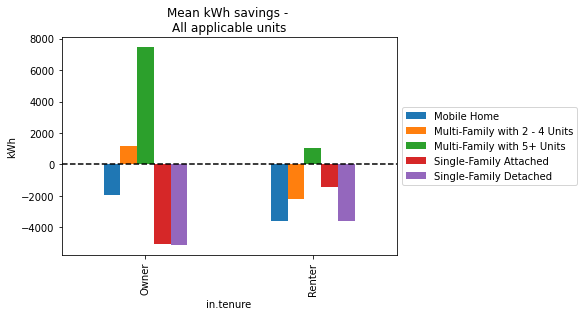

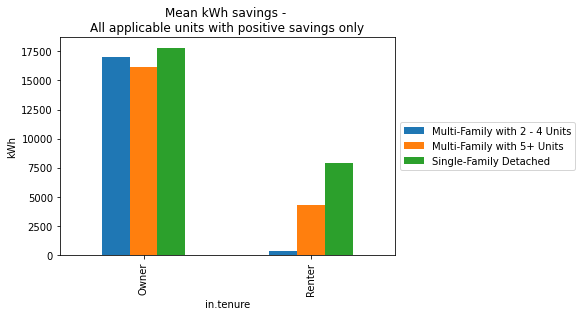

In [304]:
# 2. visualize
metric = "out.electricity.total.energy_consumption.kwh.savings"
housing_features = ["in.geometry_building_type_recs", "in.tenure"]

metric_title = "Mean kWh savings"
unit = "kWh"

# plot metric mean by housing_features
df_filtered.groupby(housing_features)[metric].mean().unstack(level=0).plot(
    kind="bar", title=f"{metric_title} - \nAll applicable units")
plt.axhline(y=0, color='k', linestyle='--') 
plt.ylabel(unit)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# plot2 - excluding 0 and negative savings
non_zero = df_filtered[metric]>0
df_filtered.loc[non_zero].groupby(housing_features)[metric].mean().unstack(level=0).plot(
    kind="bar", title=f"{metric_title} - \nAll applicable units with positive savings only")
plt.ylabel(unit)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

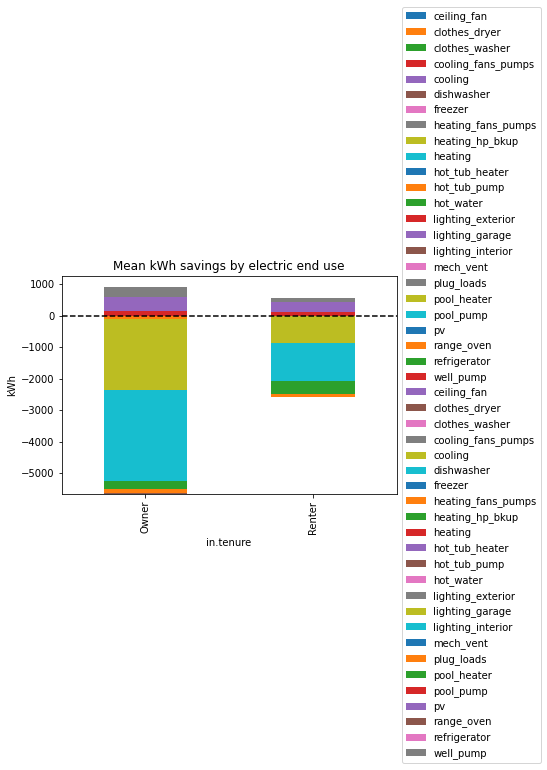

In [305]:
# plot stacked mean (total_load / unit_count) savings by end uses - ELECTRIC
end_uses = [col for col in df_filtered.columns if (
    ("savings" in col) & ("electricity" in col) & ("total" not in col) & ("net" not in col)
    )]
housing_features = ["in.tenure"]

# get mean by end use, rename end use cols by retaining only end use names
dff = df_filtered.copy()
# To ensures it's population avg 
# (i.e., if a unit doesn't have a particular end_use, it's still being counted, we need to do fillna)
# this yields the same results total_consumption / unit_count
dff[end_uses] = dff[end_uses].fillna(0)
dff = dff.groupby(housing_features)[end_uses].mean()\
    .rename(columns=lambda x: x.split(".")[2])
    
# plot
dff.plot(kind="bar", stacked=True, title="Mean kWh savings by electric end use")
plt.axhline(y=0, color='k', linestyle='--') 
plt.ylabel("kWh")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

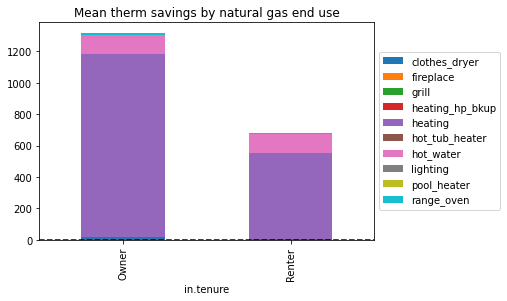

In [275]:
# plot stacked mean (total_load / unit_count) savings by end uses - NATURAL GAS
end_uses = [col for col in df_filtered.columns if (
    ("savings" in col) & ("natural_gas" in col) & ("total" not in col) & ("net" not in col)
    )]
housing_features = ["in.tenure"]

# get mean by end use, rename end use cols by retaining only end use names
dff = df_filtered.copy()
dff[end_uses] = dff[end_uses].fillna(0) # To ensures it's population avg
dff = dff.groupby(housing_features)[end_uses].mean()\
    .rename(columns=lambda x: x.split(".")[2])

# because ng is in kwh, need to convert to therms
dff *= kwh_to_therm
    
# plot
dff.plot(kind="bar", stacked=True, title="Mean therm savings by natural gas end use")
plt.axhline(y=0, color='k', linestyle='--') 
plt.ylabel("therms")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [276]:
## if you wanna be fancy, you can try using this func
def plot_aggregated_metric(df2, groupby_cols: list, value_col: str, operation="mean", weight_col=None, non_zero=False, unstack_level=0, **kwargs):
    n_by = len(groupby_cols)
    if n_by not in [1, 2]:
        raise ValueError(f"groupby_cols={groupby_cols} can have one or two columns only")

    if non_zero:
        df = df2.loc[df2[value_col]>0].copy()
        ext = " (non-zero)"
    else:
        df = df2.copy()
        ext = ""

    if weight_col is not None:
        df[value_col] *= df[weight_col]

    if operation == "mean":
        df = df.groupby(groupby_cols)[value_col].mean()
        btype = "avg customer"
    elif operation == "sum":
        df = df.groupby(groupby_cols)[value_col].sum()
        btype = "all customer (unweighted)"
        if weight_col is not None:
            btype = "all customer"
    elif operation == "min":
        df = df.groupby(groupby_cols)[value_col].min()
        btype = "smallest consumer"
    elif operation == "max":
        df = df.groupby(groupby_cols)[value_col].max()
        btype = "largest consumer"
    elif operation == "count":
        df = df.groupby(groupby_cols)[value_col].count()
        btype = "count of samples"
    else:
        raise ValueError(f"operation={operation} not supported")

    if n_by == 2:
        df = df.unstack(level=unstack_level)
        cols = df.columns
        cols = sorted(cols, key=extract_left_edge)
        cols_name = df.columns.name
        df = df[cols]

    f = plt.figure()
    df.plot(kind="bar", title=f"{value_col} - \n{btype}{ext}",  ax=f.gca(), **kwargs)
    plt.axhline(y=0, color='k', linestyle='--') 
    if n_by == 2:
        plt.legend(loc='center left', title=cols_name, bbox_to_anchor=(1.0, 0.5))

/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_28286/3132430121.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[value_col] *= df[weight_col]


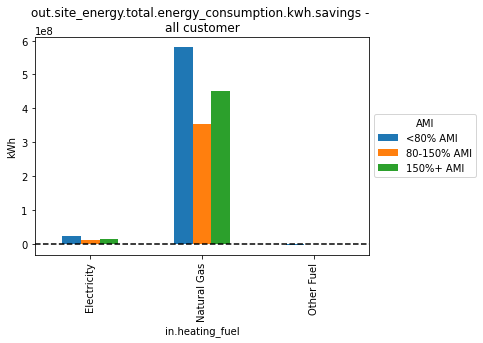

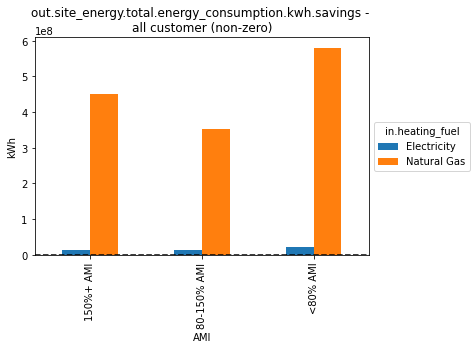

In [307]:
# Example - system aggregates (total of all customers)
groupby_cols = ["AMI", "in.heating_fuel"]
value_col = "out.site_energy.total.energy_consumption.kwh.savings"
plot_aggregated_metric(
    df_filtered, groupby_cols, value_col, 
    operation="sum", 
    weight_col="weight", 
    non_zero=False, 
    unstack_level=0, # this controls whether data pivots on the first or second para in groupby_cols
    ylabel="kWh",
)

plot_aggregated_metric(
    df_filtered, groupby_cols, value_col, 
    operation="sum", 
    weight_col="weight", 
    non_zero=True, # taking positive savings only
    unstack_level=1, # changing to 1 here so you can see
    ylabel="kWh",
)


#### 2. Histograms

In [271]:
# helper func for histogram
def plot_histogram(df2, value_col: str, by_col: str, non_zero=False, title_prefix=None, **kwargs):
    if title_prefix is None:
        title_prefix = ""
    else:
        title_prefix = f"{title_prefix.title()} "

    if "figsize" in kwargs:
        fig = plt.figure(figsize=kwargs["figsize"])
        del kwargs["figsize"]
    else:
        fig = plt.figure()
        
    df = df2[~df2[by_col].isna()].reset_index()
    ext = ""
    if non_zero:
        df = df[df[value_col]>0].reset_index()
        ext = " (non-zero)"

    title = f"{title_prefix}{value_col}{ext}"
        
    df = df.set_index([df.index, by_col])[value_col].unstack().dropna(how="all")
    cols = sorted(df.columns, key=extract_left_edge)
    df[cols].plot(kind="hist", subplots=True, sharex=True, sharey=True, ax=fig.gca(), **kwargs)
    fig.suptitle(title)
    fig.tight_layout()

/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_28286/1480035638.py:24: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[cols].plot(kind="hist", subplots=True, sharex=True, sharey=True, ax=fig.gca(), **kwargs)


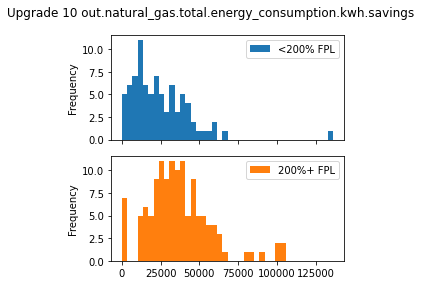

In [272]:
value_col = "out.natural_gas.total.energy_consumption.kwh.savings"
by_col = "FPL" # single para in str
upgrade_no = df["upgrade"].unique()[0]

plot_histogram(
    df_filtered, value_col, by_col, 
    non_zero=False, 
    title_prefix=f"Upgrade {upgrade_no}", 
    bins=40, 
    figsize=(4,4),
    )

### B.2. Percent (Fractional) savings

In [298]:
df_filtered = calculate_fraction_savings(df_filtered)

fraction_saving_cols = [col for col in df_filtered if "fraction_savings" in col]
df_filtered[fraction_saving_cols]

123       0.750245
7695      0.754928
10707     0.741140
12852     0.730078
14196     0.724679
            ...   
541680    0.688899
542747    0.633714
543364    0.781500
544772    0.522391
546676    0.753221
Name: out.site_energy.total.energy_consumption.fraction_savings, Length: 209, dtype: float64

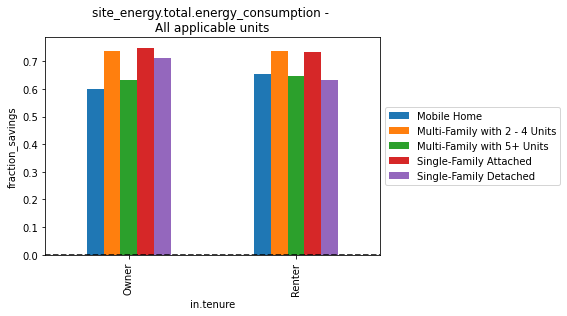

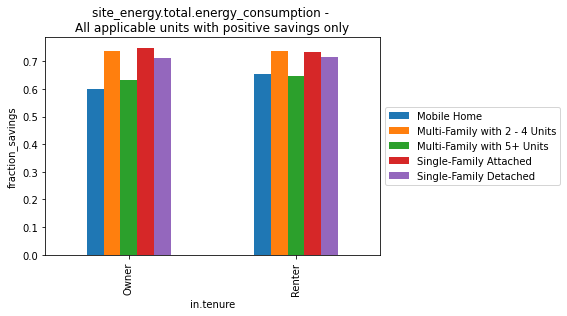

In [303]:
metric = "out.site_energy.total.energy_consumption.fraction_savings"
housing_features = ["in.geometry_building_type_recs", "in.tenure"]

metric_title = ".".join(metric.split(".")[1:-1])
unit = metric.split(".")[-1]

# plot metric mean by housing_features
df_filtered.groupby(housing_features)[metric].mean().unstack(level=0).plot(
    kind="bar", title=f"{metric_title} - \nAll applicable units")
plt.axhline(y=0, color='k', linestyle='--') 
plt.ylabel(unit)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# plot2 - excluding 0 and negative savings
non_zero = df_filtered[metric]>0
df_filtered.loc[non_zero].groupby(housing_features)[metric].mean().unstack(level=0).plot(
    kind="bar", title=f"{metric_title} - \nAll applicable units with positive savings only")
plt.ylabel(unit)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))